## Movielens 100k - Content-based exploratory analysis

In [1]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import RegexpTokenizer
import re
import string
import random
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
moviesDF = pd.read_csv("ml-latest-small/movies.csv", sep=",")
moviesDF.movieId = moviesDF.movieId.astype(int)

# Extract years
moviesDF["year"] = moviesDF.title.str.extract(r'\(([0-9]+)\)')
moviesDF["year"] = moviesDF.year.astype("float")

# Extract genres
moviesDF["genres"] = moviesDF.genres.str.split("|")
moviesDF.fillna(0, inplace=True)

moviesDF

,movieId,title,genres,year
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995.0
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",1995.0
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",1995.0
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",1995.0
4,5,Father of the Bride Part II (1995),[Comedy],1995.0
...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),"[Action, Animation, Comedy, Fantasy]",2017.0
9738,193583,No Game No Life: Zero (2017),"[Animation, Comedy, Fantasy]",2017.0
9739,193585,Flint (2017),[Drama],2017.0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),"[Action, Animation]",2018.0


### Genre Distribution

<AxesSubplot: >

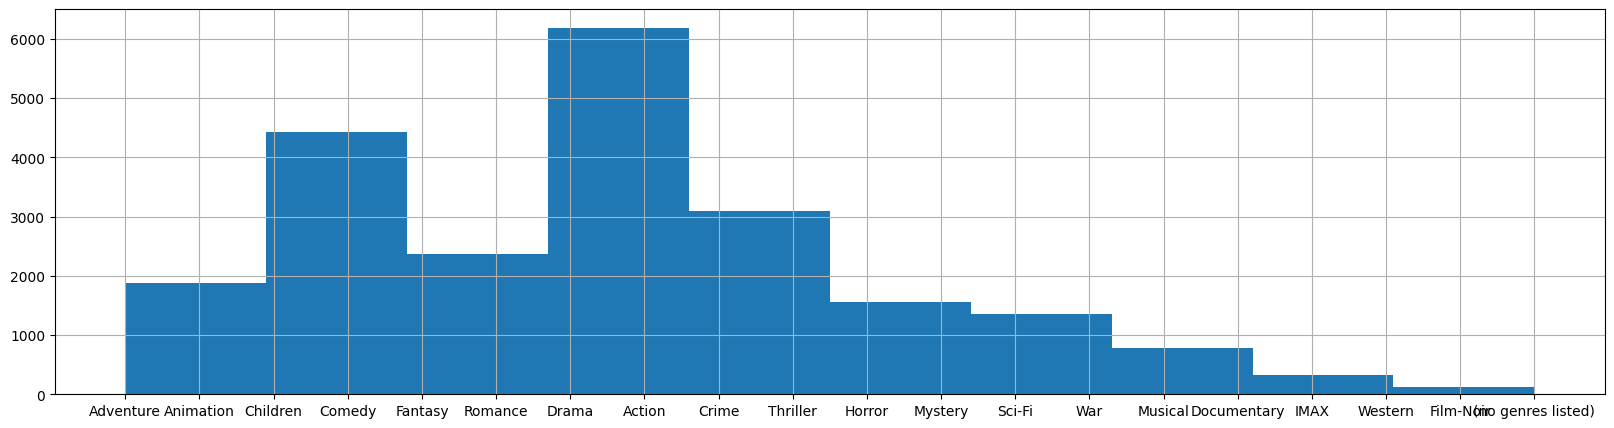

In [3]:
genres = pd.Series(np.concatenate(moviesDF.genres.values))
genres.hist(figsize = (20,5))

In [4]:
genres.unique()

array(['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy',
       'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror',
       'Mystery', 'Sci-Fi', 'War', 'Musical', 'Documentary', 'IMAX',
       'Western', 'Film-Noir', '(no genres listed)'], dtype=object)

### Year Distribution

<AxesSubplot: >

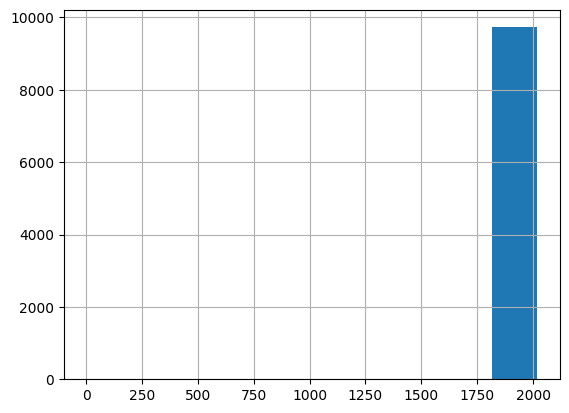

In [5]:
moviesDF.year.hist() # most of the movies are novel

### (User-made) Tags Distribution

In [6]:
tagsDF = pd.read_csv("ml-latest-small/tags.csv", sep=",")
tagsDF

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
...,...,...,...,...
3678,606,7382,for katie,1171234019
3679,606,7936,austere,1173392334
3680,610,3265,gun fu,1493843984
3681,610,3265,heroic bloodshed,1493843978


Tags are written by users as plain-text/description, so we can use TF-IDF for vectorization.

In [7]:
tagsDF.tag.unique().shape # unique Tag count

(1589,)

## Content-based Feature extraction and Item-Item Similarities

Processing title

In [8]:
moviesDF['titleCleaned'] = moviesDF.title.str.replace(r'\(([0-9]+)\)$', "").str.strip()

Processing genres

In [9]:
def process_genres(genre_list):
    out = []
    for g in genre_list:
        g = g.lower()
        if (g == "(no genres listed)"):
            out.append("")
        else:
            out.append(g)
    return " ".join(out)

moviesDF.genres = moviesDF.genres.apply(process_genres)

Processing tags

In [10]:
STOPS = set(stopwords.words("english"))

# Function for removing NonAscii characters
def remove_non_ascii(s):
    return "".join([i for i in str(s) if ord(i)<128])

# Function for converting into lower case
def get_lower_case(text):
    return str(text).lower()

# Function for removing stop words
def remove_stop_words(text):
    text = str(text).split()
    text = " ".join([w for w in text if not w in STOPS])
    return text

# Function for removing punctuation
def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = " ".join(tokenizer.tokenize(str(text)))
    return text

In [11]:
# Applying all the preprocessing functions and storing as cleaned tags
tagsDF['tagCleaned'] = tagsDF.tag.apply(remove_non_ascii)
tagsDF['tagCleaned'] = tagsDF.tagCleaned.apply(get_lower_case)
tagsDF['tagCleaned'] = tagsDF.tagCleaned.apply(remove_stop_words)
tagsDF['tagCleaned'] = tagsDF.tagCleaned.apply(remove_punctuation)

In [12]:
tags = []
for ind in moviesDF.index:
    tags.append(" ".join(tagsDF.tagCleaned.loc[tagsDF.movieId == ind]))
moviesDF["tags"] = tags
moviesDF

,movieId,title,genres,year,titleCleaned,tags
0,1,Toy Story (1995),adventure animation children comedy fantasy,1995.0,Toy Story,
1,2,Jumanji (1995),adventure children fantasy,1995.0,Jumanji,pixar pixar fun
2,3,Grumpier Old Men (1995),comedy romance,1995.0,Grumpier Old Men,fantasy magic board game robin williams game
3,4,Waiting to Exhale (1995),comedy drama romance,1995.0,Waiting to Exhale,moldy old
4,5,Father of the Bride Part II (1995),comedy,1995.0,Father of the Bride Part II,
...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),action animation comedy fantasy,2017.0,Black Butler: Book of the Atlantic,
9738,193583,No Game No Life: Zero (2017),animation comedy fantasy,2017.0,No Game No Life: Zero,
9739,193585,Flint (2017),drama,2017.0,Flint,
9740,193587,Bungo Stray Dogs: Dead Apple (2018),action animation,2018.0,Bungo Stray Dogs: Dead Apple,


In [13]:
# Saving mapping for future use (evaluation)
np.save("mappings/map_tags.npy", pd.Series(moviesDF.tags, index=moviesDF.movieId))

Similarity functions for respective CB features

In [14]:
def get_title_similarity(data: pd.DataFrame):
    # Converting the movie title into vectors by using bigrams (better results)
    tf = TfidfVectorizer(analyzer='word', ngram_range=(2, 2), min_df = 1, stop_words='english')
    tfidf_matrix = tf.fit_transform(data['titleCleaned'])
    
    # Calculating the similarity measures based on Cosine Similarity
    sg = cosine_similarity(tfidf_matrix, tfidf_matrix)
    return sg

In [15]:
def get_tag_similarity(data: pd.DataFrame):
    # Converting movie tags into vectors by using onegrams (single words)
    tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 1), stop_words='english')
    tfidf_matrix = tf.fit_transform(data['tags'])
    
    sg = cosine_similarity(tfidf_matrix, tfidf_matrix)
    return sg

In [16]:
def get_genre_similarity(data: pd.DataFrame):
    # Converting movie genres into count vectors
    count_matrix = CountVectorizer().fit_transform(data["genres"])
    
    sg = cosine_similarity(count_matrix, count_matrix)
    return sg

In [17]:
# Auxiliary function to recommend items based on movieTitle and optional parameters
def recommend(titles: list, genres : list = None, yearMin = 1800, yearMax = 3000, useTitleSim = False, top_k=10):
    def check_genre(genre_list: list):
        for g in genre_list:
            if g in genres:
                return True
        return False
    
    # Matching the genre with the dataset and reset the index
    data = moviesDF.loc[moviesDF.year >= yearMin]
    data = data.loc[data.year <= yearMax]
    if genres != None:
        data = data.loc[data.genres.apply(check_genre)]
    data.reset_index(level = 0, inplace = True)

    # Convert the index into series
    indices = pd.Series(data.index, index = data['titleCleaned'])
    
    title_sim = get_title_similarity(data) if useTitleSim else None
    tag_sim = get_tag_similarity(data)
        
    sim_total = None
    for title in titles:
        # Get the index corresponding to original_title
        idx = indices[title] # Get the pairwsie similarity scores
        
        sim = list(enumerate(title_sim[idx] + tag_sim[idx])) if useTitleSim \
            else list(enumerate(tag_sim[idx])) # Sort the movies
        
        sim_total = sim if sim_total is None else sim_total + sim
    
    sim_total = sorted(sim_total, key=lambda x: x[1], reverse=True) # Scores of the top_k most similar movies
    sim_total = sim_total[1:top_k+1] # Movie indicies
    movie_indices = [i[0] for i in sim_total]
    
    # Top 20 movie recommendation
    rec = data.loc[movie_indices]
    rec["similarityScore"] = [i[1] for i in sim_total]
    
    return rec

### Applying similarity functions

In [18]:
# Convert the index into series for future inverse mapping
indices = pd.Series(moviesDF.movieId, index = moviesDF.index)

In [19]:
def get_item_item_sim_df(*similarity_functions):
    similarity = None
    # Apply all similarity functions and simply sum the similarity matrices element-wise
    for sim in similarity_functions:
        similarity = sim(moviesDF) if similarity is None else similarity + sim(moviesDF)

    # Flatten the NP Array to get (movieId movieId similarity) Dataframe
    x1 = np.repeat(np.arange(similarity.shape[0]), len(similarity.flatten())/len(np.arange(similarity.shape[0])))
    x2 = np.tile(np.arange(similarity.shape[1]), int(len(similarity.flatten())/len(np.arange(similarity.shape[1]))))
    x3 = similarity.flatten()

    dataframe = pd.DataFrame(np.array([x1,x2,x3]).T, columns=["movieId1","movieId2","similarity"])
    dataframe.movieId1 = dataframe.movieId1.astype(int).map(indices)
    dataframe.movieId2 = dataframe.movieId2.astype(int).map(indices)
    
    return dataframe

In [20]:
title_sim = get_item_item_sim_df(get_title_similarity)
title_sim.head()

,movieId1,movieId2,similarity
0,1,1,1.0
1,1,2,0.0
2,1,3,0.0
3,1,4,0.0
4,1,5,0.0


In [21]:
title_sim = title_sim.loc[title_sim.similarity > 0].loc[title_sim.movieId1 != title_sim.movieId2]
title_sim

,movieId1,movieId2,similarity
2355,1,3114,1.000000
7355,1,78499,1.000000
22065,3,3450,0.438800
26097,3,55820,0.438800
27807,3,107408,0.224922
...,...,...,...
94694940,189333,3623,0.429691
94698439,189333,45186,0.429691
94700014,189333,91630,0.342897
94700679,189333,111781,0.342897


In [22]:
tag_sim = get_item_item_sim_df(get_tag_similarity)
tag_sim = tag_sim.loc[tag_sim.similarity > 0].loc[tag_sim.movieId1 != tag_sim.movieId2]
tag_sim

,movieId1,movieId2,similarity
10038,2,338,0.020286
12097,2,3114,0.888541
12856,2,4189,0.557373
20455,3,1272,0.211898
20588,3,1437,0.211898
...,...,...,...
87856275,140523,3915,0.330398
87856860,140523,4788,1.000000
87857253,140523,5475,0.357447
87860143,140523,60397,0.420516


In [23]:
genre_sim = get_item_item_sim_df(get_genre_similarity)
genre_sim = genre_sim.loc[genre_sim.similarity > 0].loc[genre_sim.movieId1 != genre_sim.movieId2]
genre_sim

,movieId1,movieId2,similarity
1,1,2,0.774597
2,1,3,0.316228
3,1,4,0.258199
4,1,5,0.447214
6,1,7,0.316228
...,...,...,...
94906553,193609,191005,0.447214
94906554,193609,193565,0.447214
94906556,193609,193571,0.707107
94906559,193609,193581,0.500000


In [24]:
title_tag_sim = get_item_item_sim_df(get_title_similarity, get_tag_similarity)
title_tag_sim = title_tag_sim.loc[title_tag_sim.similarity > 0].loc[title_tag_sim.movieId1 != title_tag_sim.movieId2]
title_tag_sim

,movieId1,movieId2,similarity
2355,1,3114,1.000000
7355,1,78499,1.000000
10038,2,338,0.020286
12097,2,3114,0.888541
12856,2,4189,0.557373
...,...,...,...
94694940,189333,3623,0.429691
94698439,189333,45186,0.429691
94700014,189333,91630,0.342897
94700679,189333,111781,0.342897


In [25]:
title_genre_sim = get_item_item_sim_df(get_title_similarity, get_genre_similarity)
title_genre_sim = title_genre_sim.loc[title_genre_sim.similarity > 0].loc[title_genre_sim.movieId1 != title_genre_sim.movieId2]
title_genre_sim

,movieId1,movieId2,similarity
1,1,2,0.774597
2,1,3,0.316228
3,1,4,0.258199
4,1,5,0.447214
6,1,7,0.316228
...,...,...,...
94906553,193609,191005,0.447214
94906554,193609,193565,0.447214
94906556,193609,193571,0.707107
94906559,193609,193581,0.500000


### Saving CB similarities for Evaluation

In [26]:
title_sim.to_csv("title_sim.dat", index=False, header=False, sep="\t", encoding="CP1250")
tag_sim.to_csv("tag_sim.dat", index=False, header=False, sep="\t", encoding="CP1250")
genre_sim.to_csv("genre_sim.dat", index=False, header=False, sep="\t", encoding="CP1250")
title_tag_sim.to_csv("title_tag_sim.dat", index=False, header=False, sep="\t", encoding="CP1250")
title_genre_sim.to_csv("title_genre_sim.dat", index=False, header=False, sep="\t", encoding="CP1250")

## Summary

Content-based filtering on MovieLens dataset which includes using features such as:
- simple filtering: genre, year
- VSM: title, tag, title + tags
- filtering based on novelty and similar time periods

The complete 27M-dataset also includes "genome-scores.csv" and "genome-tags.csv" to identify relevance of tags given by users to specific movies:
- "tag"-only filtering could be improved by adding such scores to them
- also the tags in 100k dataset are extremely sparsed, with many movies having zero tags